In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 50

In this notebook, we analyze data from [MeteoLausanne](http://meteolausanne.com/) and, in particular, we extract *temperature* and *wind* information.  

These quantities, along with *irradiance*, constitute the features of a regression model for the power produced at EPFL in the first six months of 2016.

**Note:** At the end, we just use data from MeteoSwiss's Idaweb but this was a fundamental step in our project since it allowed us to develop our solution for Lausanne.

# Load data

The measurements are in a text file where columns are separated by tab. Moreover, the header takes the first two rows.

In [2]:
full_df = pd.read_csv('../data/meteolausanne.txt', header=[0,1], sep='\t', low_memory=False)
full_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0  Temp    Hi   Low Out  Dew  Wind       \
                Date               Time   Out  Temp  Temp Hum  Pt. Speed  Dir   
0           13/06/08              15:30  15.7  15.7  15.4  46  4.1   1.6   NE   
1           13/06/08              15:40  15.6  15.7  15.6  49  4.9   6.4  NNE   
2           13/06/08              15:50  15.7  15.7  15.6  47  4.4   3.2   NE   
3           13/06/08              16:00  15.4  15.8  15.4  49  4.8   4.8   NW   
4           13/06/08              16:10  15.3  15.4  15.3  49  4.7   4.8   NW   

           Hi       Wind  Heat   THW  THSW Unnamed: 16_level_0  \
    Run Speed  Dir Chill Index Index Index               Bar     
0  0.27   9.7   NE  15.7  14.4  14.4   ---              1013.2   
1  1.07  19.3  NNE  15.6  14.4  14.4   ---              1013.2   
2  0.54  12.9   NE  15.7  14.5  14.5   ---              1013.2   
3  0.80  19.3  NNW  15.4  14.3  14.3   ---              1013.1   
4  0.80  16.1  NNW  15.3  14.2  14.2   ---              1013.1   

  Unnamed: 17_level_0 Rain Solar        Hi Solar   UV        Hi    Heat  \
                 Rain Rate  Rad. Energy    Rad.  Index Dose  UV    D-D    
0                 0.0  0.0   ---    ---      ---   ---  ---  ---  0.019   
1                 0.0  0.0   ---    ---      ---   ---  ---  ---  0.019   
2                 0.0  0.0   ---    ---      ---   ---  ---  ---  0.018   
3                 0.0  0.0   ---    ---      ---   ---  ---  ---  0.020   
4                 0.0  0.0   ---    ---      ---   ---  ---  ---  0.021   

    Cool   In   In   In               In Air Unnamed: 33_level_0 Wind      \
    D-D   Temp Hum   Dew  Heat   EMC Density                 ET  Samp Tx    
0  0.000  25.3  44  12.2  25.1  8.20  1.1665                 0.0  175   1   
1  0.000  25.2  45  12.4  24.9  8.40  1.1670                 0.0   95   1   
2  0.000  25.1  45  12.3  24.8  8.41  1.1675                 0.0  232   1   
3  0.000  25.1  45  12.3  24.8  8.41  1.1674                 0.0  233   1   
4  0.000  24.9  45  12.2  24.7  8.41  1.1680                 0.0  230   1   

    ISS  Arc.  
  Recept Int.  
0   76.8   10  
1   41.7   10  
2  100.0   10  
3  100.0   10  
4  100.0   10

# Handling missing values

We firstly change the representation of missing values from "---" to "-1".

In [3]:
full_df.replace("---", -1, inplace=True)
full_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0  Temp    Hi   Low Out  Dew  Wind       \
                Date               Time   Out  Temp  Temp Hum  Pt. Speed  Dir   
0           13/06/08              15:30  15.7  15.7  15.4  46  4.1   1.6   NE   
1           13/06/08              15:40  15.6  15.7  15.6  49  4.9   6.4  NNE   
2           13/06/08              15:50  15.7  15.7  15.6  47  4.4   3.2   NE   
3           13/06/08              16:00  15.4  15.8  15.4  49  4.8   4.8   NW   
4           13/06/08              16:10  15.3  15.4  15.3  49  4.7   4.8   NW   

           Hi       Wind  Heat   THW  THSW Unnamed: 16_level_0  \
    Run Speed  Dir Chill Index Index Index               Bar     
0  0.27   9.7   NE  15.7  14.4  14.4    -1              1013.2   
1  1.07  19.3  NNE  15.6  14.4  14.4    -1              1013.2   
2  0.54  12.9   NE  15.7  14.5  14.5    -1              1013.2   
3  0.80  19.3  NNW  15.4  14.3  14.3    -1              1013.1   
4  0.80  16.1  NNW  15.3  14.2  14.2    -1              1013.1   

  Unnamed: 17_level_0 Rain Solar        Hi Solar   UV       Hi    Heat   Cool  \
                 Rain Rate  Rad. Energy    Rad.  Index Dose UV    D-D    D-D    
0                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.019  0.000   
1                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.019  0.000   
2                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.018  0.000   
3                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.020  0.000   
4                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.021  0.000   

    In   In   In               In Air Unnamed: 33_level_0 Wind       ISS  Arc.  
   Temp Hum   Dew  Heat   EMC Density                 ET  Samp Tx  Recept Int.  
0  25.3  44  12.2  25.1  8.20  1.1665                 0.0  175   1   76.8   10  
1  25.2  45  12.4  24.9  8.40  1.1670                 0.0   95   1   41.7   10  
2  25.1  45  12.3  24.8  8.41  1.1675                 0.0  232   1  100.0   10  
3  25.1  45  12.3  24.8  8.41  1.1674                 0.0  233   1  100.0   10  
4  24.9  45  12.2  24.7  8.41  1.1680                 0.0  230   1  100.0   10

And we only collect those measurements for which the temperature is not null.

In [4]:
useful_indx = full_df["Temp"]["Out"] != "---"

In [5]:
useful_indx.value_counts()

True    733371
Name: Out, dtype: int64

Thus, there are only few measurements missing temperature.

In [6]:
usefuldata = full_df.loc[useful_indx]
usefuldata.head()

Unnamed: 0_level_0 Unnamed: 1_level_0  Temp    Hi   Low Out  Dew  Wind       \
                Date               Time   Out  Temp  Temp Hum  Pt. Speed  Dir   
0           13/06/08              15:30  15.7  15.7  15.4  46  4.1   1.6   NE   
1           13/06/08              15:40  15.6  15.7  15.6  49  4.9   6.4  NNE   
2           13/06/08              15:50  15.7  15.7  15.6  47  4.4   3.2   NE   
3           13/06/08              16:00  15.4  15.8  15.4  49  4.8   4.8   NW   
4           13/06/08              16:10  15.3  15.4  15.3  49  4.7   4.8   NW   

           Hi       Wind  Heat   THW  THSW Unnamed: 16_level_0  \
    Run Speed  Dir Chill Index Index Index               Bar     
0  0.27   9.7   NE  15.7  14.4  14.4    -1              1013.2   
1  1.07  19.3  NNE  15.6  14.4  14.4    -1              1013.2   
2  0.54  12.9   NE  15.7  14.5  14.5    -1              1013.2   
3  0.80  19.3  NNW  15.4  14.3  14.3    -1              1013.1   
4  0.80  16.1  NNW  15.3  14.2  14.2    -1              1013.1   

  Unnamed: 17_level_0 Rain Solar        Hi Solar   UV       Hi    Heat   Cool  \
                 Rain Rate  Rad. Energy    Rad.  Index Dose UV    D-D    D-D    
0                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.019  0.000   
1                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.019  0.000   
2                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.018  0.000   
3                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.020  0.000   
4                 0.0  0.0    -1     -1       -1    -1   -1  -1  0.021  0.000   

    In   In   In               In Air Unnamed: 33_level_0 Wind       ISS  Arc.  
   Temp Hum   Dew  Heat   EMC Density                 ET  Samp Tx  Recept Int.  
0  25.3  44  12.2  25.1  8.20  1.1665                 0.0  175   1   76.8   10  
1  25.2  45  12.4  24.9  8.40  1.1670                 0.0   95   1   41.7   10  
2  25.1  45  12.3  24.8  8.41  1.1675                 0.0  232   1  100.0   10  
3  25.1  45  12.3  24.8  8.41  1.1674                 0.0  233   1  100.0   10  
4  24.9  45  12.2  24.7  8.41  1.1680                 0.0  230   1  100.0   10

A plot of the temperature over the years 2008-2016 is shown here:

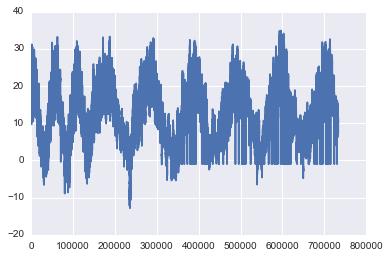

In [7]:
plt.plot(usefuldata["Temp"]["Out"].apply(float))

# Data Wrangling

We create a dataframe with timestamp, temperature and wind.

In [8]:
date_df = usefuldata["Unnamed: 0_level_0"]
time_df = usefuldata["Unnamed: 1_level_0"]
temp_df = usefuldata["Temp"]["Out"].astype(float)
wind_df = usefuldata["Wind"]["Speed"].astype(float)

In [9]:
tempWind_df = pd.concat([date_df,time_df,temp_df,wind_df],axis=1)
tempWind_df = tempWind_df.rename(columns = {"Out":"Temp", "Speed":"Wind"})
tempWind_df.head()

,Date,Time,Temp,Wind
0,13/06/08,15:30,15.7,1.6
1,13/06/08,15:40,15.6,6.4
2,13/06/08,15:50,15.7,3.2
3,13/06/08,16:00,15.4,4.8
4,13/06/08,16:10,15.3,4.8


We now set "Date" as index

In [10]:
tempWind_df = tempWind_df.set_index("Date")

and only pick data from Jan 1, 2016 to July 10, 2016.
This is the data we are interested in because we only have the produced solar power at EPFL in this time span.

In [11]:
usefulData = tempWind_df.ix['01/01/16':'10/07/16']
usefulData.tail()

,Time,Temp,Wind
Date,,,
10/07/16,23:35,27.0,0.0
10/07/16,23:40,26.9,1.6
10/07/16,23:45,26.9,0.0
10/07/16,23:50,26.9,1.6
10/07/16,23:55,26.9,0.0


We now create a new column in the DataFrame that merges the "Date" and "Time" information into a _datetime_ value.

In [12]:
usefulData = usefulData.reset_index()
dateTime = pd.to_datetime(usefulData['Date'] + ' ' + usefulData['Time'], dayfirst=True)
usefulData['dateTime'] = dateTime
usefulData.tail()

,Date,Time,Temp,Wind,dateTime
55278,10/07/16,23:35,27.0,0.0,2016-07-10 23:35:00
55279,10/07/16,23:40,26.9,1.6,2016-07-10 23:40:00
55280,10/07/16,23:45,26.9,0.0,2016-07-10 23:45:00
55281,10/07/16,23:50,26.9,1.6,2016-07-10 23:50:00
55282,10/07/16,23:55,26.9,0.0,2016-07-10 23:55:00


We then use this new column as index of our DataFrame and drop other date and time information.

In [13]:
usefulData = usefulData.set_index(dateTime)
usefulData = usefulData.drop(['Date', 'Time', 'dateTime'], axis=1)
usefulData.tail()

,Temp,Wind
2016-07-10 23:35:00,27.0,0.0
2016-07-10 23:40:00,26.9,1.6
2016-07-10 23:45:00,26.9,0.0
2016-07-10 23:50:00,26.9,1.6
2016-07-10 23:55:00,26.9,0.0


The frequency of this data is 5 minutes. 
However, the frequency of the data on solar power produced at ELL building is 1 minute. Thus, we interpolate:

In [14]:
usefulData1Min = usefulData.resample('1Min').mean()
usefulData1Min.tail(20)

,Temp,Wind
2016-07-10 23:36:00,NaN,NaN
2016-07-10 23:37:00,NaN,NaN
2016-07-10 23:38:00,NaN,NaN
2016-07-10 23:39:00,NaN,NaN
2016-07-10 23:40:00,26.9,1.6
2016-07-10 23:41:00,NaN,NaN
2016-07-10 23:42:00,NaN,NaN
2016-07-10 23:43:00,NaN,NaN
2016-07-10 23:44:00,NaN,NaN
2016-07-10 23:45:00,26.9,0.0


In [15]:
usefulData1Min = usefulData1Min.interpolate()
usefulData1Min.head(10)

,Temp,Wind
2016-01-01 00:00:00,7.10,0.0
2016-01-01 00:01:00,7.14,0.0
2016-01-01 00:02:00,7.18,0.0
2016-01-01 00:03:00,7.22,0.0
2016-01-01 00:04:00,7.26,0.0
2016-01-01 00:05:00,7.30,0.0
2016-01-01 00:06:00,7.30,0.0
2016-01-01 00:07:00,7.30,0.0
2016-01-01 00:08:00,7.30,0.0
2016-01-01 00:09:00,7.30,0.0


We now have _temperature_ and _wind_ data for ELL building of EPFL from Jan 1, 2016 to July 10, 2016 with a frequency of 1 min. <br>
We will use these as features for training the model.

In [16]:
final_df = usefulData1Min.loc['2016-01-01 01:00:00':'2016-07-09 20:59:00']
final_df.head()

,Temp,Wind
2016-01-01 01:00:00,7.30,0.0
2016-01-01 01:01:00,7.32,0.0
2016-01-01 01:02:00,7.34,0.0
2016-01-01 01:03:00,7.36,0.0
2016-01-01 01:04:00,7.38,0.0


Finally, we save this DataFrame containing temperature and wind measurements for Lausanne in the period where solar power is produced at EPFL.

In [17]:
pickle.dump(final_df, open("ELL data/ELL_temp_wind_df.p","wb"))